In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_DATASET_PATH = '../course_project_train.csv'
TEST_DATASET_PATH = '../course_project_test.csv'

TARGET_NAME = 'Credit Default'
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [3]:
# 1. Обзор обучающего датасета

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


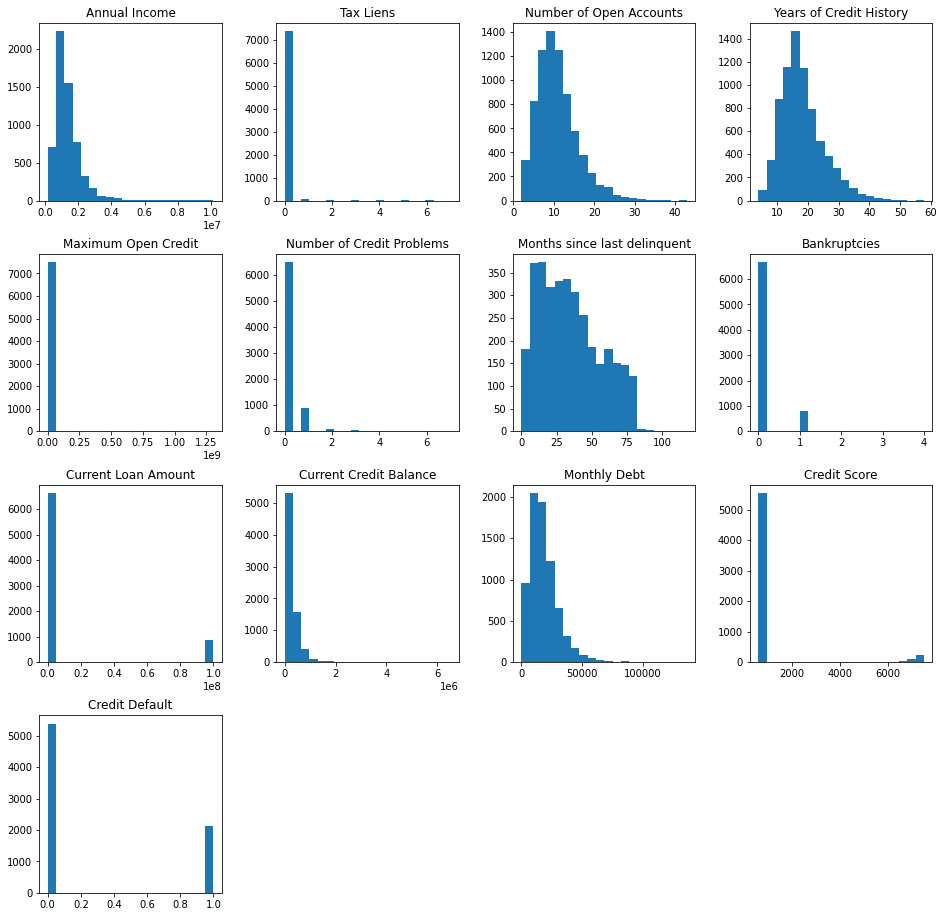

In [7]:
df_num_features = df_train.select_dtypes(include=['float64', 'float32', 'float16', 'int64'])
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [8]:
not_defaulted = df_train.loc[df_train['Credit Default'] == 0]
not_defaulted.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,4.359000e+03,5387.000000,5387.000000,5387.000000,5.387000e+03,5387.000000,2436.000000,5377.000000,5.387000e+03,5.387000e+03,5387.000000,4359.000000,5387.0
mean,1.418047e+06,0.025988,11.042138,18.408168,1.088422e+06,0.163727,34.656814,0.116794,1.640219e+07,2.937194e+05,18176.425469,723.577885,0.0
std,8.845096e+05,0.256502,4.871796,6.959349,1.890526e+07,0.480127,21.516233,0.344130,3.669223e+07,3.359989e+05,11917.013432,25.412545,0.0
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,590.000000,0.0
25%,8.663525e+05,0.000000,8.000000,13.700000,2.895860e+05,0.000000,17.000000,0.000000,1.798060e+05,1.145035e+05,9894.500000,713.000000,0.0
50%,1.225747e+06,0.000000,10.000000,17.100000,4.937460e+05,0.000000,32.000000,0.000000,3.145340e+05,2.092850e+05,15939.000000,732.000000,0.0
75%,1.709572e+06,0.000000,14.000000,22.000000,8.233610e+05,0.000000,50.000000,0.000000,5.510780e+05,3.629095e+05,23717.500000,742.000000,0.0
max,1.014934e+07,7.000000,43.000000,51.900000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,751.000000,0.0


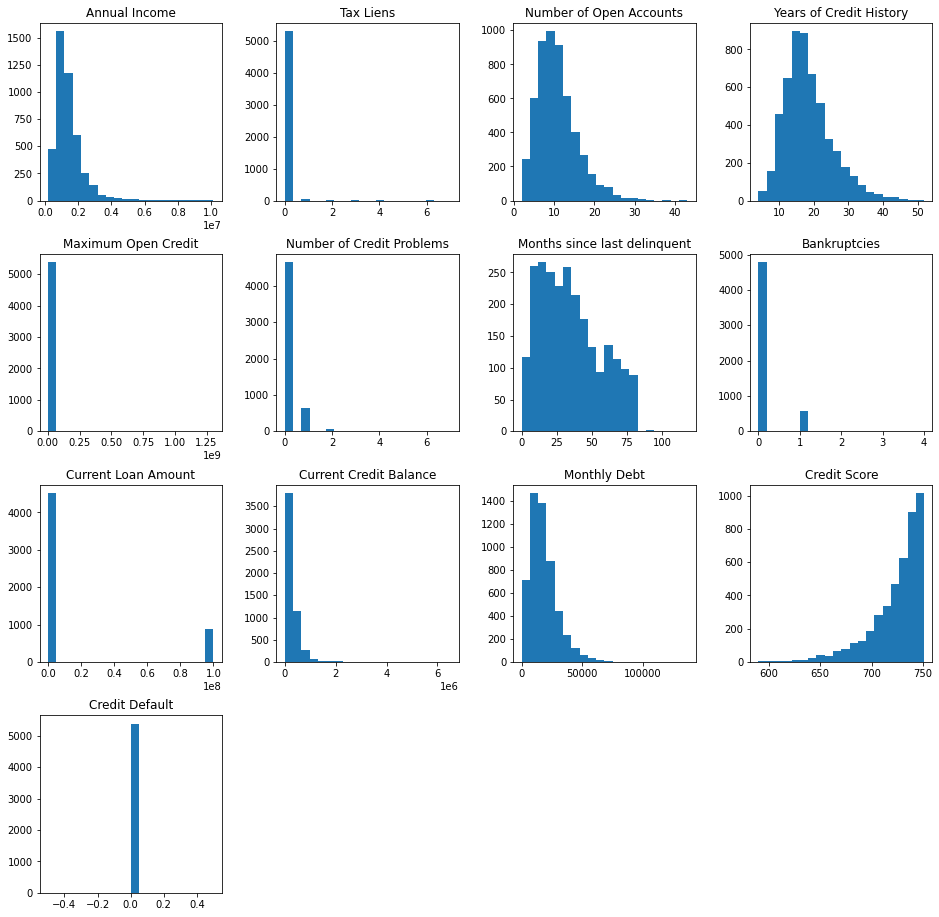

In [9]:
df_num_features = not_defaulted.select_dtypes(include=['float64', 'float32', 'float16', 'int64'])
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [10]:
defaulted = df_train.loc[df_train['Credit Default'] == 1]
defaulted.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1.584000e+03,2113.000000,2113.000000,2113.000000,2.113000e+03,2113.000000,983.000000,2109.000000,2113.000000,2.113000e+03,2113.000000,1584.000000,2113.0
mean,1.224243e+06,0.040700,11.357312,18.086228,5.798982e+05,0.185991,34.781282,0.118065,326651.044013,2.799256e+05,18666.352106,2327.548611,1.0
std,7.077733e+05,0.306572,4.996364,7.244804,5.517541e+05,0.542644,22.121493,0.354961,186027.080635,2.659432e+05,11947.197046,2787.985441,0.0
min,1.940280e+05,0.000000,2.000000,4.500000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,585.000000,1.0
25%,7.726730e+05,0.000000,8.000000,13.100000,2.562560e+05,0.000000,15.000000,0.000000,181610.000000,1.124610e+05,10534.000000,704.000000,1.0
50%,1.055916e+06,0.000000,11.000000,16.700000,4.420900e+05,0.000000,33.000000,0.000000,290576.000000,2.101020e+05,16390.000000,730.500000,1.0
75%,1.493894e+06,0.000000,14.000000,21.500000,7.279580e+05,0.000000,52.000000,0.000000,444708.000000,3.536470e+05,24057.000000,6162.500000,1.0
max,8.710740e+06,5.000000,42.000000,57.700000,6.639358e+06,5.000000,86.000000,4.000000,788634.000000,3.944514e+06,104036.000000,7510.000000,1.0


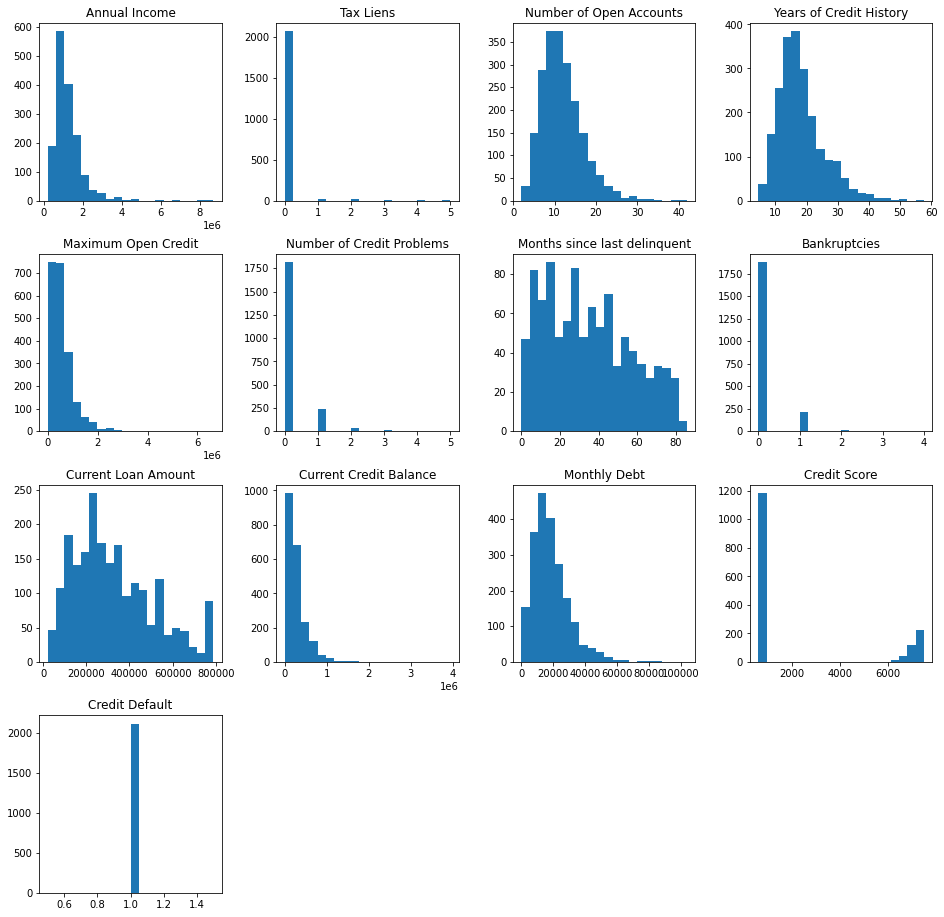

In [11]:
df_num_features = defaulted.select_dtypes(include=['float64', 'float32', 'float16', 'int64'])
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

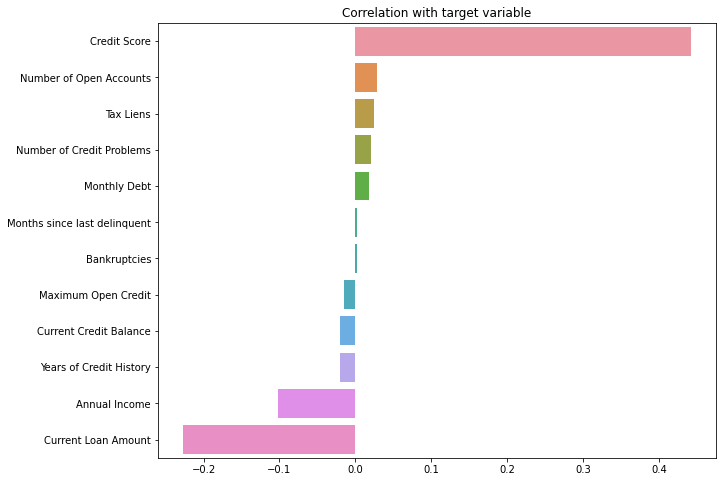

In [12]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [13]:
# 2. Обработка выбросов

# Ничего не выбрасываем.

In [14]:
# 3. Обработка пропусков

df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [15]:
median = df_train['Annual Income'].median()
df_train['Annual Income'].fillna(median, inplace=True)
df_test['Annual Income'].fillna(median, inplace=True)

In [16]:
delinquent_na = df_train.loc[df_train['Months since last delinquent'].isna()]
delinquent_na.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,4.081000e+03,4081.000000,4081.000000,4081.000000,4.081000e+03,4081.000000,0.0,4081.000000,4.081000e+03,4.081000e+03,4081.000000,3207.000000,4081.000000
mean,1.281602e+06,0.016908,10.848812,17.439108,1.131019e+06,0.147268,NaN,0.118598,1.249968e+07,3.171025e+05,18002.123989,1152.682881,0.276893
std,7.251932e+05,0.168495,4.994941,6.964835,2.087128e+07,0.418474,NaN,0.345347,3.266303e+07,3.350577e+05,12123.304466,1599.889769,0.447518
min,1.758450e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,NaN,0.000000,2.147200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.767170e+05,0.000000,7.000000,12.600000,3.049200e+05,0.000000,NaN,0.000000,1.791680e+05,1.264640e+05,9709.000000,714.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,16.300000,5.317620e+05,0.000000,NaN,0.000000,3.099360e+05,2.311350e+05,15507.000000,734.000000,0.000000
75%,1.438110e+06,0.000000,13.000000,20.900000,8.671080e+05,0.000000,NaN,0.000000,5.340720e+05,4.038450e+05,23607.000000,745.000000,1.000000
max,9.338880e+06,3.000000,43.000000,52.200000,1.304726e+09,4.000000,NaN,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [17]:
# При отсутсвие данных в столбце 'Months since last delinquent' mean Credit Default почти что не меняется. По этому будем считать что это отсутвие данных, а не то что не разу не было delinquent месяца.

def delinquent_month_update(df, median):
    df['delinquent_nan'] = 0
    df.loc[df['Months since last delinquent'].isna(), 'delinquent_nan'] = 1

    df['Months since last delinquent'].fillna(median, inplace=True)

In [18]:
median = df_train['Months since last delinquent'].median()

delinquent_month_update(df_train, median)
delinquent_month_update(df_test, median)

In [19]:
credit_score_na = df_train.loc[df_train['Credit Score'].isna()]
credit_score_na.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,delinquent_nan
count,1557.0,1557.000000,1557.000000,1557.000000,1.557000e+03,1557.000000,1557.000000,1555.000000,1557.000000,1.557000e+03,1557.000000,0.0,1557.000000,1557.000000
mean,1168386.0,0.033398,11.151574,18.336737,1.489092e+06,0.171484,33.133590,0.113826,300744.253051,2.860604e+05,18451.107900,NaN,0.339756,0.561336
std,0.0,0.280313,4.935590,7.038592,3.305621e+07,0.500137,14.447098,0.327673,179179.260062,3.048984e+05,12084.036473,NaN,0.473778,0.496383
min,1168386.0,0.000000,2.000000,4.300000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,NaN,0.000000,0.000000
25%,1168386.0,0.000000,8.000000,13.500000,2.832280e+05,0.000000,32.000000,0.000000,167684.000000,1.140760e+05,10071.000000,NaN,0.000000,0.000000
50%,1168386.0,0.000000,10.000000,17.300000,4.862660e+05,0.000000,32.000000,0.000000,262856.000000,2.058650e+05,16048.000000,NaN,0.000000,1.000000
75%,1168386.0,0.000000,14.000000,21.900000,7.942660e+05,0.000000,32.000000,0.000000,404096.000000,3.572190e+05,23883.000000,NaN,1.000000,1.000000
max,1168386.0,4.000000,33.000000,51.900000,1.304726e+09,5.000000,83.000000,2.000000,788942.000000,3.944514e+06,96177.000000,NaN,1.000000,1.000000


In [20]:
# При отсутсвие данных в столбце 'Credit Score' mean Credit Default сильно меняется. По этому считаем что это отсутвие данных, а не то что не разу не было delinquent месяца.

credit_score_empty = df_train[df_train["Credit Score"].between(650, 700)]
credit_score_empty.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,delinquent_nan
count,8.740000e+02,874.000000,874.000000,874.000000,8.740000e+02,874.000000,874.000000,873.000000,8.740000e+02,8.740000e+02,874.000000,874.000000,874.000000,874.000000
mean,1.354421e+06,0.027460,11.433638,17.862586,5.839530e+05,0.202517,34.548055,0.142039,7.776433e+06,3.037682e+05,19932.415332,681.316934,0.336384,0.456522
std,8.700886e+05,0.227897,5.225571,6.589252,7.554047e+05,0.536369,16.409580,0.389641,2.615679e+07,3.225879e+05,12056.256591,13.739818,0.472743,0.498391
min,1.758450e+05,0.000000,2.000000,4.900000,0.000000e+00,0.000000,1.000000,0.000000,2.222000e+04,0.000000e+00,280.000000,650.000000,0.000000,0.000000
25%,8.444265e+05,0.000000,8.000000,13.500000,2.593965e+05,0.000000,32.000000,0.000000,2.232725e+05,1.143658e+05,11612.750000,671.000000,0.000000,0.000000
50%,1.159712e+06,0.000000,11.000000,16.850000,4.440700e+05,0.000000,32.000000,0.000000,3.656070e+05,2.236965e+05,17625.500000,684.000000,0.000000,0.000000
75%,1.588685e+06,0.000000,14.000000,21.275000,6.949855e+05,0.000000,37.750000,0.000000,5.490705e+05,3.884455e+05,25855.250000,693.000000,1.000000,1.000000
max,1.014934e+07,4.000000,43.000000,57.700000,1.476048e+07,6.000000,91.000000,4.000000,1.000000e+08,4.367245e+06,104036.000000,700.000000,1.000000,1.000000


In [21]:
# Средняк примерно в диапазоне 675.

def credit_score_update(df):
    df['credit_score_nan'] = 0
    df.loc[df_train['Credit Score'].isna(), 'credit_score_nan'] = 1

    df['Credit Score'].fillna(675, inplace=True)

In [22]:
credit_score_update(df_train)
credit_score_update(df_test)

In [23]:
df_train['Bankruptcies'].fillna(0, inplace=True)
df_test['Bankruptcies'].fillna(0, inplace=True)

In [24]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,delinquent_nan,credit_score_nan
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,33.227467,0.116933,1.187318e+07,2.898332e+05,18314.454133,1052.251733,0.281733,0.544133,0.207600
std,7.567551e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,14.703950,0.346904,3.192612e+07,3.178714e+05,11926.764673,1441.203228,0.449874,0.498082,0.405616
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,675.000000,0.000000,0.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,722.000000,0.000000,1.000000,0.000000
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,32.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000,1.000000,0.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,1.000000,1.000000


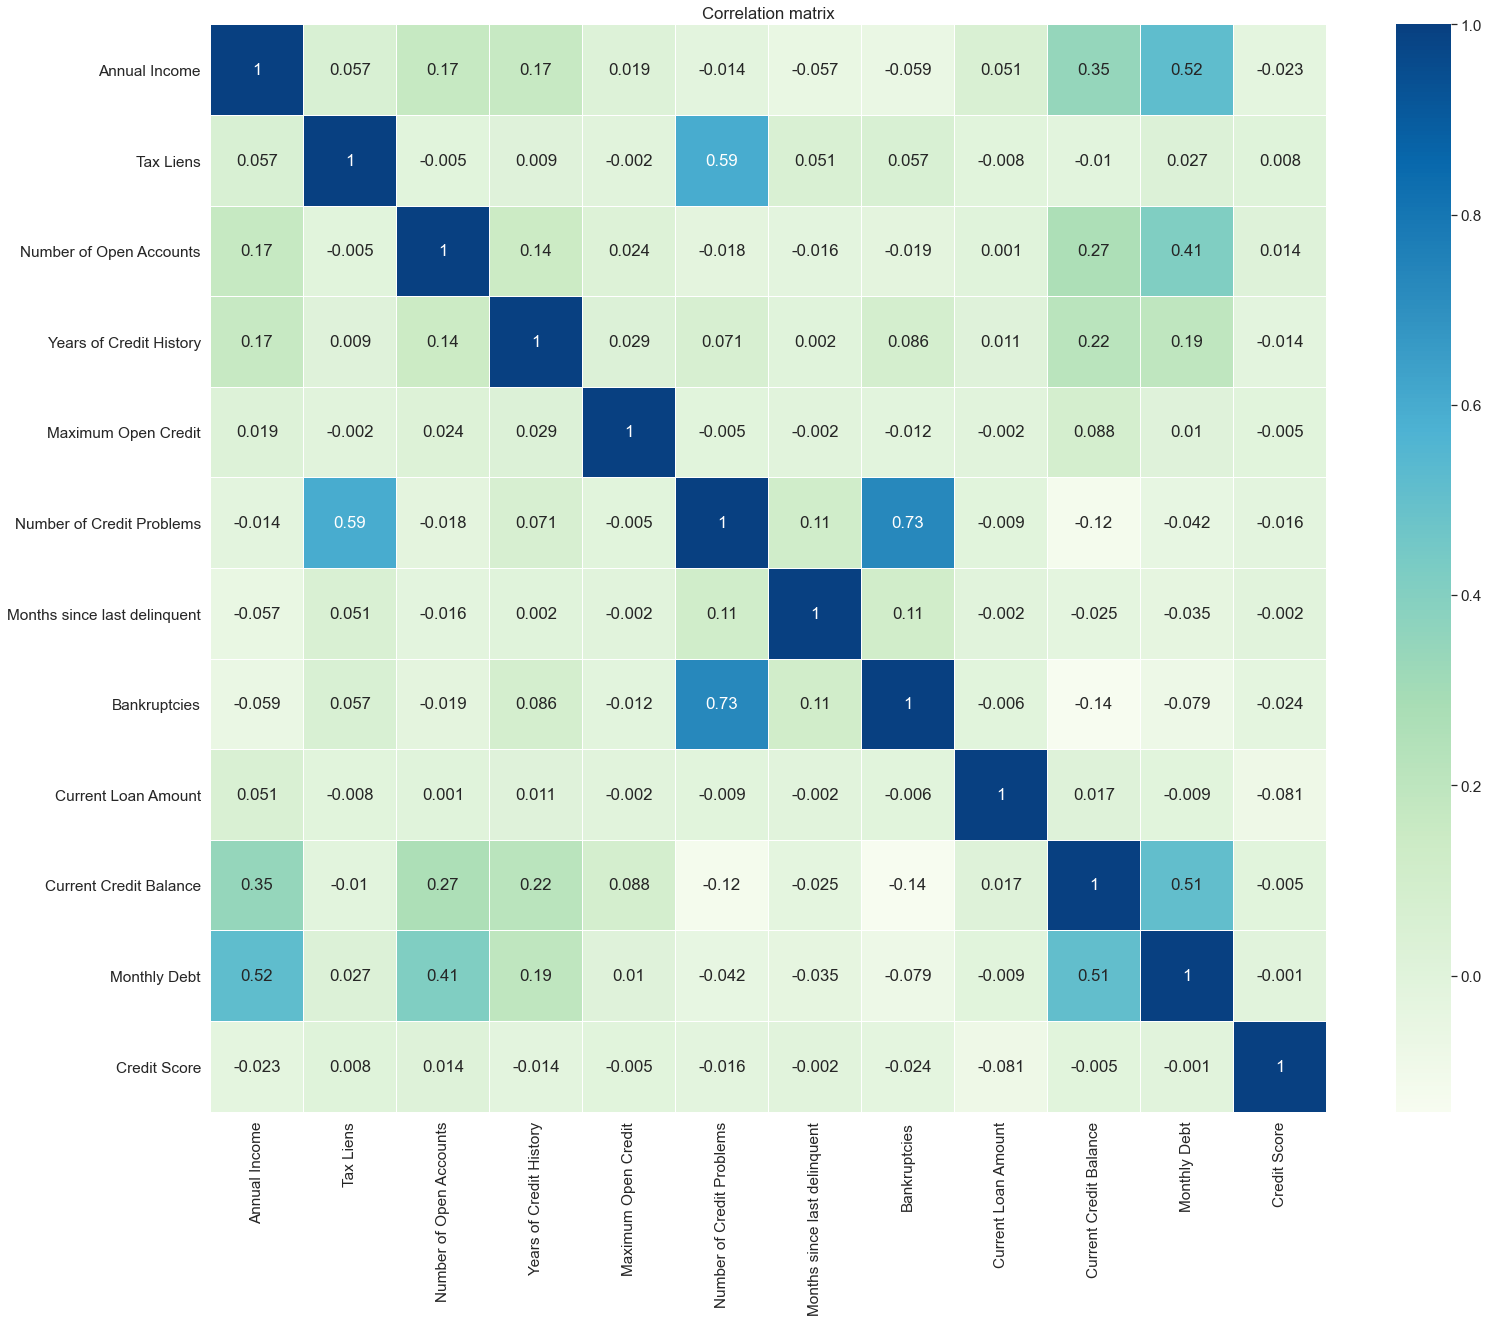

In [25]:
# 4. Анализ данных

BASE_FEATURE_NAMES.remove('Home Ownership')
BASE_FEATURE_NAMES.remove('Purpose')
BASE_FEATURE_NAMES.remove('Term')

plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [26]:
# 5. Отбор признаков

# Исплоьзуем main_df чтоб в обоих датафреймах были одинаковые признаки.

def add_dummies(df, main_df):
    df = pd.concat([df, pd.get_dummies(main_df['Home Ownership'])], axis=1)
    df = pd.concat([df, pd.get_dummies(main_df['Purpose'])], axis=1)
    df = pd.concat([df, pd.get_dummies(main_df['Term'])], axis=1)
    return df

df_train = add_dummies(df_train, df_train)
df_test = add_dummies(df_test, df_train)

df_train.drop(columns=['Home Ownership', 'Purpose', 'Term'], inplace=True)
df_test.drop(columns=['Home Ownership', 'Purpose', 'Term'], inplace=True)

df_train.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding,Long Term,Short Term
0,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,99999999.0,...,0,0,0,0,0,0,0,0,0,1
1,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,264968.0,...,0,0,0,0,0,0,0,0,1,0
2,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,99999999.0,...,0,0,0,0,0,0,0,0,0,1
3,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,121396.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,125840.0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [28]:
job_years_empty = df_train.loc[df_train['Years in current job'].isna()]
job_years_empty.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding,Long Term,Short Term
count,3.710000e+02,371.000000,371.000000,371.000000,3.710000e+02,371.000000,371.000000,371.000000,3.710000e+02,3.710000e+02,...,371.000000,371.0,371.000000,371.0,371.000000,371.000000,371.0,371.0,371.000000,371.000000
mean,9.732200e+05,0.072776,10.242588,23.193531,6.643533e+05,0.369272,35.035040,0.247978,1.125918e+07,2.576993e+05,...,0.005391,0.0,0.134771,0.0,0.002695,0.005391,0.0,0.0,0.161725,0.838275
std,4.717085e+05,0.385673,4.311571,9.907511,8.782026e+05,0.735967,14.770363,0.490962,3.132201e+07,3.234698e+05,...,0.073323,0.0,0.341940,0.0,0.051917,0.073323,0.0,0.0,0.368696,0.368696
min,1.758450e+05,0.000000,2.000000,4.900000,0.000000e+00,0.000000,3.000000,0.000000,2.219800e+04,0.000000e+00,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,5.900450e+05,0.000000,7.000000,15.600000,2.460370e+05,0.000000,32.000000,0.000000,1.217700e+05,8.769450e+04,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000
50%,1.004872e+06,0.000000,10.000000,21.100000,4.474800e+05,0.000000,32.000000,0.000000,2.187460e+05,1.690240e+05,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000
75%,1.168386e+06,0.000000,12.000000,29.250000,7.164630e+05,1.000000,35.500000,0.000000,4.088480e+05,3.096620e+05,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000
max,3.904215e+06,4.000000,32.000000,57.700000,8.947840e+06,5.000000,92.000000,3.000000,1.000000e+08,4.209659e+06,...,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,1.000000


In [29]:
def job_years_update(df):
    df['job_years_nan'] = 0
    df.loc[df['Years in current job'].isna(), 'job_years_nan'] = 1
    
    df.loc[df['Years in current job'].isna(), 'months_in_job'] = 0
    df.loc[df['Years in current job'] == '< 1 year', 'months_in_job'] = 6
    df.loc[df['Years in current job'] == '1 year', 'months_in_job'] = 12
    df.loc[df['Years in current job'] == '2 years', 'months_in_job'] = 24
    df.loc[df['Years in current job'] == '3 years', 'months_in_job'] = 36
    df.loc[df['Years in current job'] == '4 years', 'months_in_job'] = 48
    df.loc[df['Years in current job'] == '5 years', 'months_in_job'] = 60
    df.loc[df['Years in current job'] == '6 years', 'months_in_job'] = 72
    df.loc[df['Years in current job'] == '7 years', 'months_in_job'] = 84
    df.loc[df['Years in current job'] == '8 years', 'months_in_job'] = 96
    df.loc[df['Years in current job'] == '9 years', 'months_in_job'] = 108
    df.loc[df['Years in current job'] == '10+ years', 'months_in_job'] = 150
    
    
    df.drop(columns=['Years in current job'], inplace=True)

In [30]:
job_years_update(df_train)
job_years_update(df_test)
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,renewable energy,small business,take a trip,vacation,wedding,Long Term,Short Term,job_years_nan,months_in_job
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.00000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,33.227467,0.116933,1.187318e+07,2.898332e+05,...,0.088667,0.000267,0.003467,0.004933,0.001067,0.00200,0.259200,0.740800,0.049467,76.852000
std,7.567551e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,14.703950,0.346904,3.192612e+07,3.178714e+05,...,0.284281,0.016329,0.058780,0.070069,0.032645,0.04468,0.438225,0.438225,0.216855,56.053305
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,1.801690e+05,1.142565e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,24.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,72.000000
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,32.000000,0.000000,5.198820e+05,3.604062e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,150.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,150.000000


In [31]:
# 6. Балансировка классов

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)     

In [32]:
feature_names = df_train.columns.tolist()
feature_names.remove('Credit Default')

FEATURE_NAMES_SELECTED = df_train.columns.drop(TARGET_NAME).tolist()
FEATURE_NAMES_SELECTED

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'delinquent_nan',
 'credit_score_nan',
 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent',
 'business loan',
 'buy a car',
 'buy house',
 'debt consolidation',
 'educational expenses',
 'home improvements',
 'major purchase',
 'medical bills',
 'moving',
 'other',
 'renewable energy',
 'small business',
 'take a trip',
 'vacation',
 'wedding',
 'Long Term',
 'Short Term',
 'job_years_nan',
 'months_in_job']

In [33]:
def scale_data(df):
    scaler = StandardScaler()
    stand_features = scaler.fit_transform(df[FEATURE_NAMES_SELECTED])

    df[FEATURE_NAMES_SELECTED] = pd.DataFrame(stand_features, columns=FEATURE_NAMES_SELECTED)


In [34]:
df_train.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,renewable energy,small business,take a trip,vacation,wedding,Long Term,Short Term,job_years_nan,months_in_job
0,482087.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,99999999.0,47386.0,...,0,0,0,0,0,0,0,1,1,0.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,264968.0,394972.0,...,0,0,0,0,0,0,1,0,0,150.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,99999999.0,308389.0,...,0,0,0,0,0,0,0,1,0,96.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,121396.0,95855.0,...,0,0,0,0,0,0,0,1,0,72.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,125840.0,93309.0,...,0,0,0,0,0,0,0,1,0,96.0


In [35]:
scale_data(df_train)
scale_data(df_test)

df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,renewable energy,small business,take a trip,vacation,wedding,Long Term,Short Term,job_years_nan,months_in_job
count,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,...,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03
mean,5.968559e-17,2.273737e-17,3.647453e-17,-2.027415e-16,-4.736952e-18,-7.010688e-17,1.170027e-16,6.347515e-17,4.831691e-17,1.326346e-17,...,6.631732e-18,-2.842171e-18,-2.178998e-17,1.989520e-17,-4.263256e-18,1.657933e-17,5.921189e-17,-5.921189e-17,1.894781e-17,-1.080025e-16
std,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,...,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00
min,-1.533873e+00,-1.109534e-01,-1.860192e+00,-2.033305e+00,-5.897941e-02,-3.409789e-01,-2.259915e+00,-3.370990e-01,-3.715680e-01,-9.118548e-01,...,-3.119188e-01,-1.633211e-02,-5.898073e-02,-7.041159e-02,-3.267730e-02,-4.476615e-02,-5.915167e-01,-1.690569e+00,-2.281249e-01,-1.371143e+00
25%,-5.208805e-01,-1.109534e-01,-6.378469e-01,-6.841558e-01,-4.155495e-02,-3.409789e-01,-8.348427e-02,-3.370990e-01,-3.662765e-01,-5.523883e-01,...,-3.119188e-01,-1.633211e-02,-5.898073e-02,-7.041159e-02,-3.267730e-02,-4.476615e-02,-5.915167e-01,-1.690569e+00,-2.281249e-01,-9.429511e-01
50%,-2.073461e-01,-1.109534e-01,-2.303985e-01,-1.871009e-01,-2.914137e-02,-3.409789e-01,-8.348427e-02,-3.370990e-01,-3.622230e-01,-2.532962e-01,...,-3.119188e-01,-1.633211e-02,-5.898073e-02,-7.041159e-02,-3.267730e-02,-4.476615e-02,-5.915167e-01,5.915167e-01,-2.281249e-01,-8.656623e-02
75%,2.308540e-01,-1.109534e-01,5.844983e-01,4.945743e-01,-9.463390e-03,-3.409789e-01,-8.348427e-02,-3.370990e-01,-3.556352e-01,2.220323e-01,...,-3.119188e-01,-1.633211e-02,-5.898073e-02,-7.041159e-02,-3.267730e-02,-4.476615e-02,1.690569e+00,5.915167e-01,-2.281249e-01,1.305059e+00
max,1.166117e+01,2.566362e+01,6.492500e+00,5.592937e+00,8.135844e+01,1.369933e+01,5.765674e+00,1.119423e+01,2.760520e+00,1.955941e+01,...,3.205962e+00,6.122908e+01,1.695469e+01,1.420221e+01,3.060229e+01,2.233831e+01,1.690569e+00,5.915167e-01,4.383564e+00,1.305059e+00


In [36]:
X = df_train[FEATURE_NAMES_SELECTED]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [37]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4074
1    3102
Name: Credit Default, dtype: int64

In [38]:
# 7. Подбор моделей, получение бейзлана
# 8. Выбор наилучшей модели, настройка гиперпараметров



In [39]:
# 9. Проверка качества, борьба с переобучением

In [40]:
# 10. Интерпретация результатов